### Import Modules

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Part 1: Loading the images

In [2]:
spine_img = cv2.imread('spineXray.tif', cv2.IMREAD_GRAYSCALE)
chest_img = cv2.imread('chest.tif', cv2.IMREAD_ANYDEPTH)
print(f'Spine image \t shape: {spine_img.shape} \t dtype: {spine_img.dtype}')
print(f'Chest image \t shape: {chest_img.shape} \t dtype: {chest_img.dtype}')

Spine image 	 shape: (706, 320) 	 dtype: uint8
Chest image 	 shape: (493, 600) 	 dtype: uint16


### Part 2: Implement performCLAHE function

CLAHE is an adoptive histogram equalization method. It divides the image into small tiles and applies histogram equalization to each tile. 

The contrast of the image is enhanced by applying adaptive histogram equalization to the image. Unless we have noise in a tile, this method works well. In order to reduce the effect of noise, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization.

The function takes the following arguments:
- ‍‍`clipLimit`: This parameter sets the threshold for contrast limiting. The default value is 40. 
- `tileGridSize`: his sets the number of tiles in the row and column. By default this is 8×8. It is used while the image is divided into tiles for applying CLAHE. 

In [3]:
def perform_clahe(img, clip_limit=40.0, tile_grid_size=(8, 8)):
    '''
    Performs CLAHE on the input image.
    :param img: Input image
    :param clip_limit: Threshold for contrast limiting
    :param tile_grid_size: Size of grid for histogram equalization
    :return img: CLAHE processed image
    '''
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

now we can test our function:

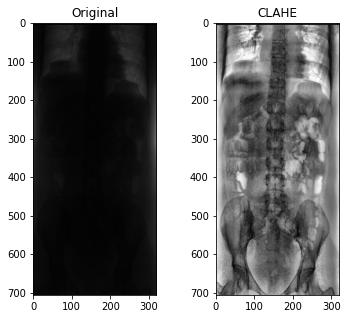

In [4]:
clahe_img = perform_clahe(spine_img)

fig, ax = plt.subplots(1, 2, figsize=(6, 5))
ax[0].imshow(spine_img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original')
ax[1].imshow(clahe_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('CLAHE')
plt.show();

### Part 3: Histogram Equalization

In this part, I will implement the histogram equalization function. It follows the following formula:  

$s = (L - 1) \int_{0}^{r} P_r(w)dw$   

Where $s$ is the mapped value, $P_r(r)$ is the input image PDF, and $L$ is the number of gray levels.  

So, to implement this function, we need to calculate the cumulative distribution function (CDF) of the input image. Then, divide it by the maximum possible value in image.

In [5]:
def hist_equalization(img, bit_depth=8):
    '''
    Performs histogram equalization on the input image.
    :param img: Input image
    :param bit_depth: Bit depth of the image
    :return img: Equalized image
    '''
    # Calculate the CDF
    cdf = np.zeros(2**bit_depth)
    for i in range(2**bit_depth):
        cdf[i] = np.sum(img <= i) / img.size

    # Calculate the equalized image
    equalized_img = np.zeros(img.shape, img.dtype)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            equalized_img[i, j] = np.round((2 ** bit_depth - 1) * cdf[img[i, j]])

    return equalized_img

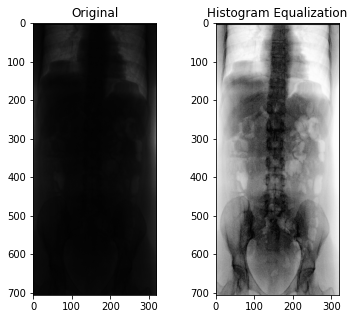

In [6]:
hist_equal_image = hist_equalization(spine_img)

fig, ax = plt.subplots(1, 2, figsize=(6, 5))
ax[0].imshow(spine_img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original')
ax[1].imshow(hist_equal_image, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Histogram Equalization')
plt.show();

### Part 4: Plotting the results

at first, we perform the functions on our images:

In [7]:
spine_clahe = perform_clahe(spine_img)
spine_hist_equal = hist_equalization(spine_img)
chest_clahe = perform_clahe(chest_img)
chest_hist_equal = hist_equalization(chest_img, bit_depth=16)

To plot the results for our spine image, we can put every 4 intensities in one bin. This will make the histogram more clear.

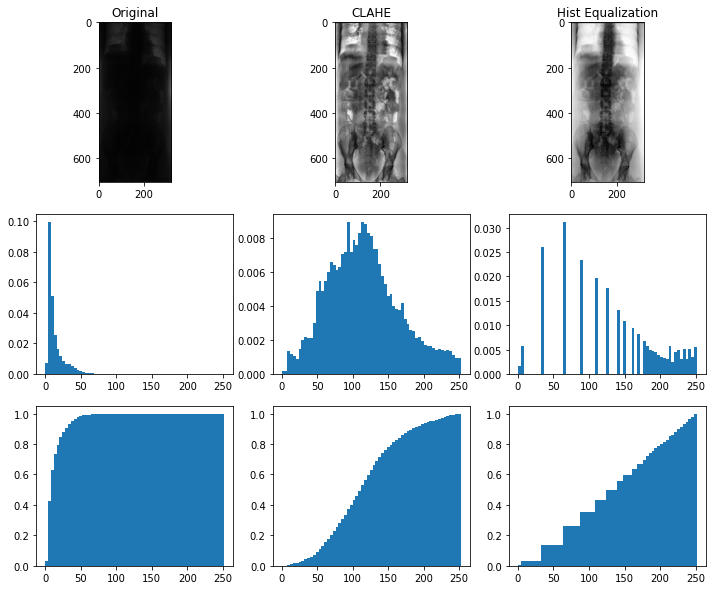

In [8]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(spine_img, cmap='gray', vmin=0, vmax=255)
ax1.set_title('Original')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(spine_clahe, cmap='gray', vmin=0, vmax=255)
ax2.set_title('CLAHE')

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(spine_hist_equal, cmap='gray', vmin=0, vmax=255)
ax3.set_title('Hist Equalization')

ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(spine_img.ravel(), bins=[i for i in range(0, 256, 4)], density = True)

ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(spine_clahe.ravel(), bins=[i for i in range(0, 256, 4)], density = True)

ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(spine_hist_equal.ravel(), bins=[i for i in range(0, 256, 4)], density = True)

ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(spine_img.ravel(), bins=[i for i in range(0, 256, 4)], density = True, cumulative = True)

ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(spine_clahe.ravel(), bins=[i for i in range(0, 256, 4)], density = True, cumulative = True)

ax7 = fig.add_subplot(gs[2, 2])
ax7.hist(spine_hist_equal.ravel(), bins=[i for i in range(0, 256, 4)], density = True, cumulative = True)

plt.show();

now we can plot the results for the chest image. It is important to consider that the chest image is a 16-bit image. So, the image values are in the range of 0 to 65535. We put every 1024 values in a bin. So, the range of each bin is 1024.

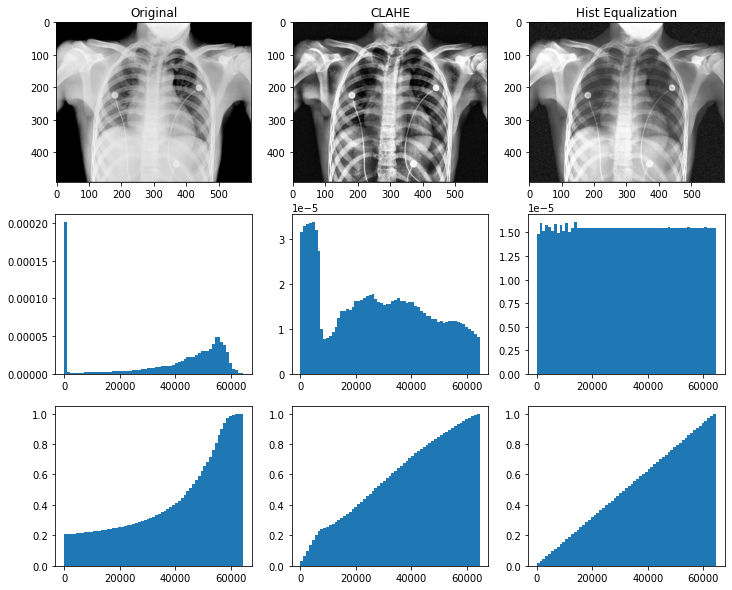

In [9]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(chest_img, cmap='gray', vmin=0, vmax=2**16 - 1)
ax1.set_title('Original')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(chest_clahe, cmap='gray', vmin=0, vmax=2**16 - 1)
ax2.set_title('CLAHE')

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(chest_hist_equal, cmap='gray', vmin=0, vmax=2**16 - 1)
ax3.set_title('Hist Equalization')

ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(chest_img.ravel(), bins=[i for i in range(0, 2**16 - 1, 1024)], density = True)

ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(chest_clahe.ravel(), bins=[i for i in range(0, 2**16 - 1, 1024)], density = True)

ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(chest_hist_equal.ravel(), bins=[i for i in range(0, 2**16 - 1, 1024)], density = True)

ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(chest_img.ravel(), bins=[i for i in range(0, 2**16 - 1, 1024)], density = True, cumulative = True)

ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(chest_clahe.ravel(), bins=[i for i in range(0, 2**16 - 1, 1024)], density = True, cumulative = True)

ax7 = fig.add_subplot(gs[2, 2])
ax7.hist(chest_hist_equal.ravel(), bins=[i for i in range(0, 2**16 - 1, 1024)], density = True, cumulative = True)

plt.show();

### Part 5: Conclusion

From the results obtained from **spine** image we can conculde that:  

1.Performing **CLAHE** filter on the image has improved the contrast of the image significantly and the resulting image contains a full range of intensities. However, regarding to the histogram, we can see that the output image is not completly balanced and the histogram is not uniform. Moreover, using another value for `clipLimit` may result to a better image. (I've used the default value of 40).

2.Using **histogram equalization** on the image has improved the contrast of the image very much and the resulting histogram contains the whole range of gray. The produced image is much more clear than the original image.

---

From the results obtained from **chest** image we can conculde that:

1.The image itself contains a suitable range of gray colors but they are not equally distributed.

2.Performing **CLAHE** filter has risen the occurence of some mid-level grays resulting to a more contrasted image. 

3.Histogram equalization method has performed very well on this image and the resulting histogram shows a nearly balanced gray range. Also, the cumulative distribution function of the image is nearly linear which means the resulting image is very balanced in terms of gray levels.

4.I don't know which of this images are better for medical purposes because I'm not a biomedical engineer. But I think the image produced by histogram equalization is better because it is more balanced in terms of gray levels and the inner parts of the chest are more clear.